In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# torch.set_default_device('cuda')
np.random.seed(1)

import os, sys
m_path = os.path.abspath(os.path.join("..\.."))
if m_path not in sys.path:
    sys.path.append(m_path)

# load data

In [2]:
import pickle
from xcloth.train.data import MeshDataSet

data_path = "../../data/test_data/"
dataset = MeshDataSet(root_dir=data_path, mask={"88-1"}, excld=False, depth_offset=.5)

dataset.stats

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


{'registered pose': 1,
 'registered mesh': 1,
 'common keys': {'88-1'},
 'extra pose': set(),
 'extra mesh': set()}

In [3]:
d = dataset[0]
print([x.shape for x in d])

[torch.Size([7, 512, 512]), torch.Size([4, 1, 512, 512]), torch.Size([4, 3, 512, 512]), torch.Size([3, 3, 512, 512])]


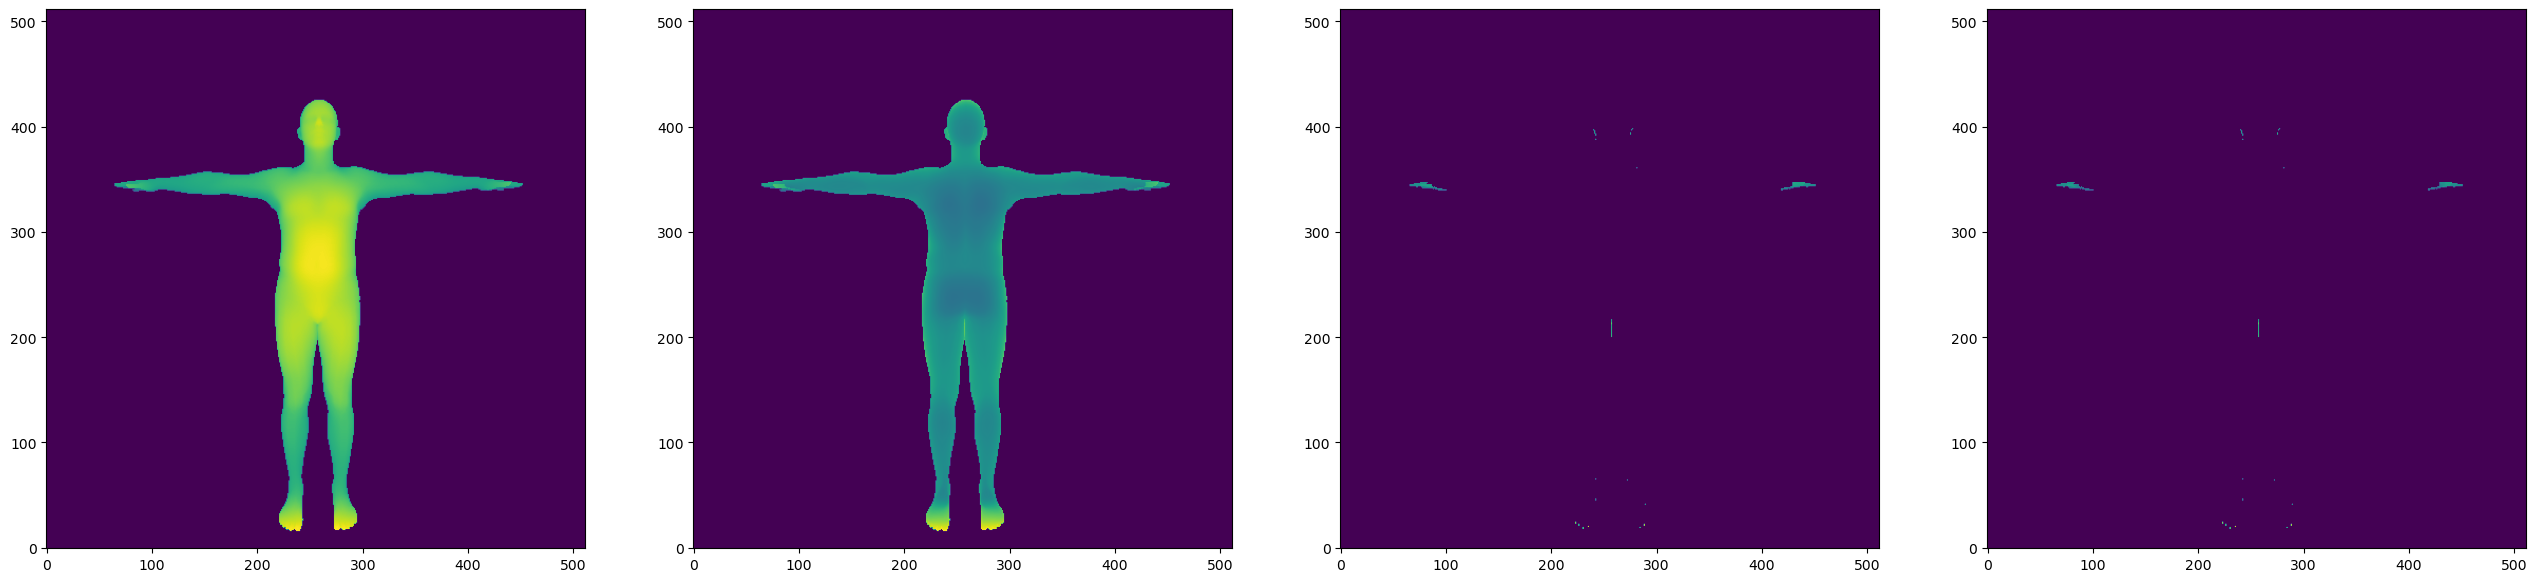

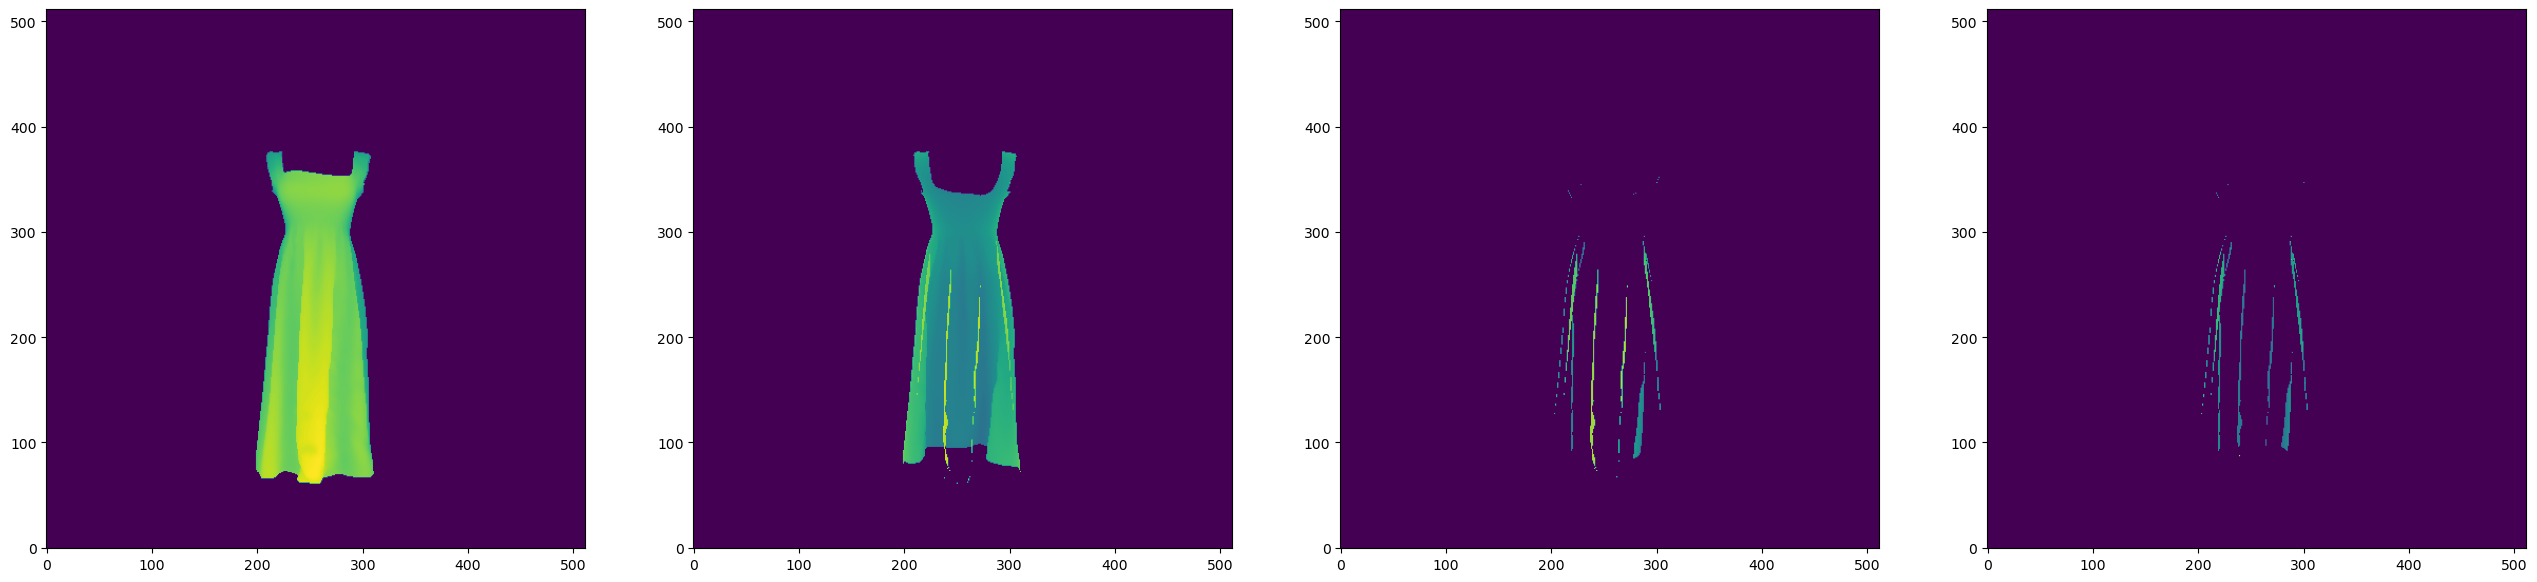

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


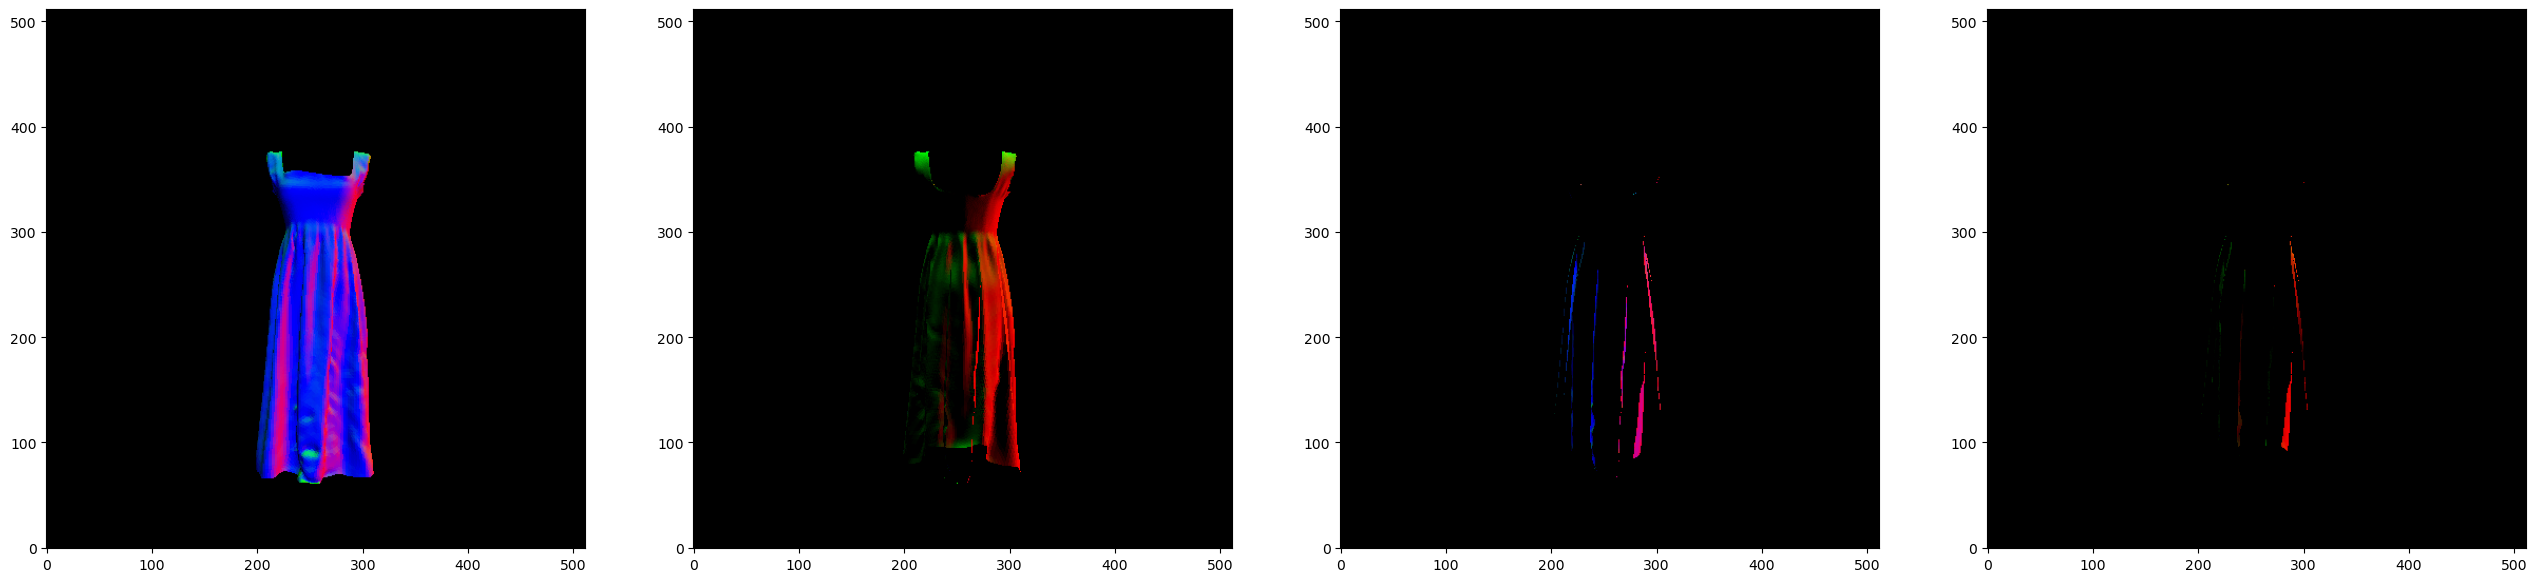

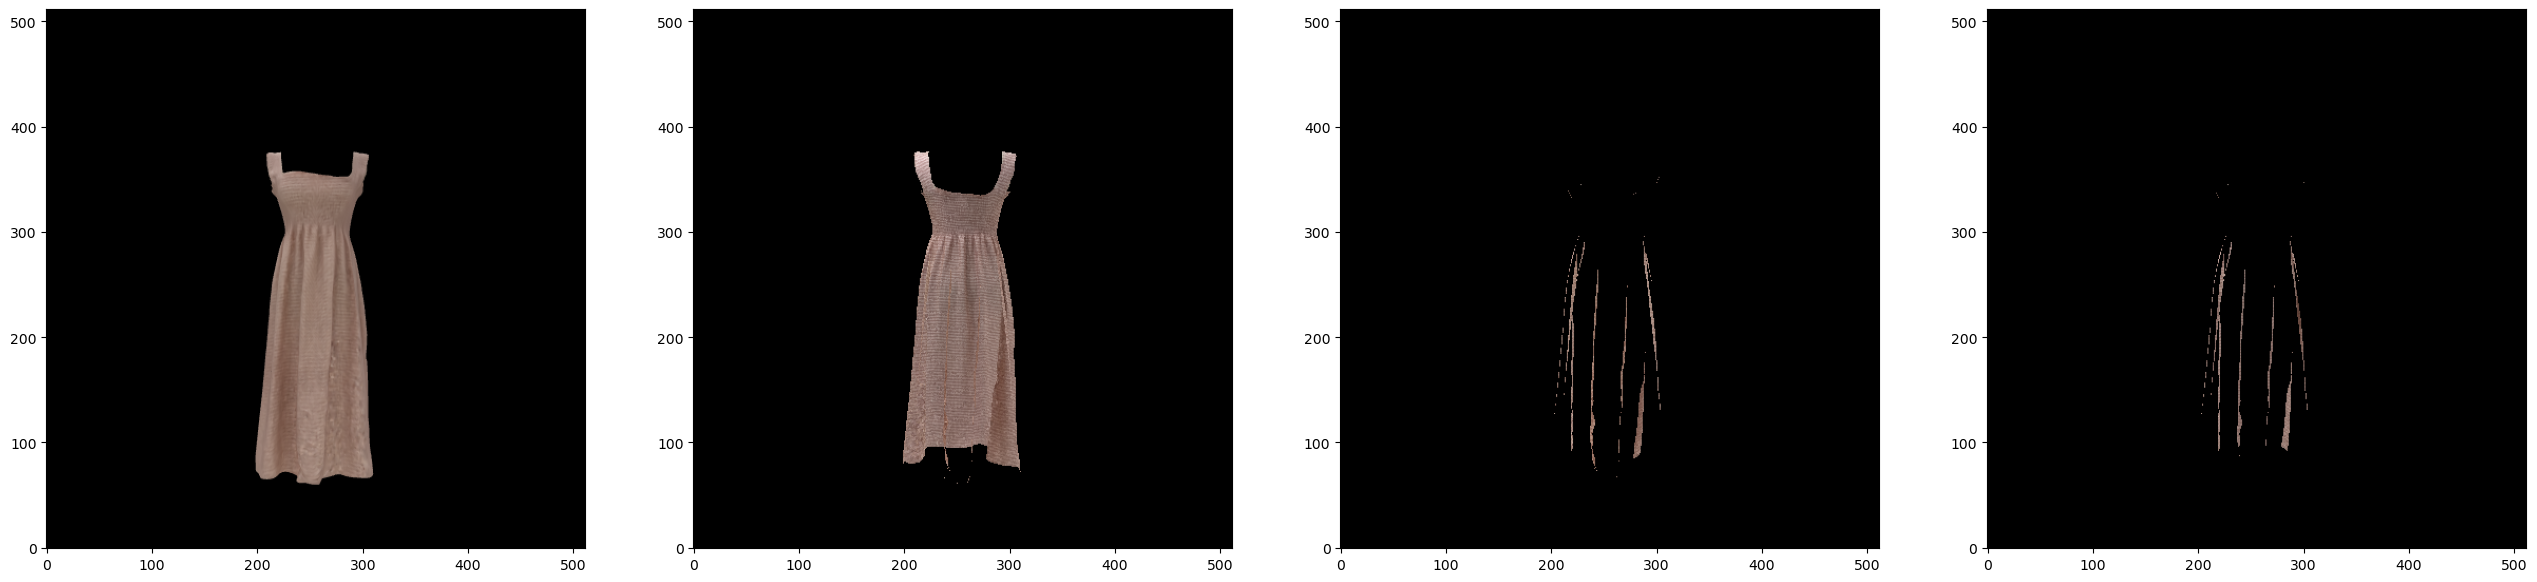

In [4]:
from matplotlib import pyplot as plt
from xcloth.utils import plot_3d, plot_depth

plot_depth(d[0][3:].cpu().numpy())
plot_depth(d[1].cpu().numpy().squeeze())
plot_3d(d[2].cpu().numpy())
plot_3d(np.concatenate([d[0][:3].unsqueeze(0).cpu().numpy(), d[3].cpu().numpy()], axis=0))

In [5]:
%%script skip

from xcloth.components.utils import GarmentModel3D

garment = GarmentModel3D(
    img=d[0][:3].cpu().numpy(),
    pm_depth=d[1].cpu().numpy(),
    pm_norm=d[2].cpu().numpy(),
    pm_rgb=d[3].cpu().numpy(),
).make_rgb()

garment.reconstruct(thres=0, depth_offset=.5)
garment.save_pcd("../no_git_test_data/88-1/reconstructed")

Couldn't find program: 'skip'


In [6]:
%%script skipped

from xcloth.train import train_model
from xcloth.production import XCloth

xcloth = XCloth().cuda()
# xcloth(sample_in, sample_smpl)

train_model(
    xcloth,
    dataset,
    verbose=True,
    n_epoch=5,
    reduction="mean",
    weight=[1., 0.1, 1., 0.05, 1, 0.5],
    params_path="../../data/test_data/params.pt",
    separate_bg=True,
)

Couldn't find program: 'skipped'


In [7]:
from xcloth.production import XCloth

model = XCloth().to(device="cpu")
model.load("../../res/xcloth/07-02-2024/xcloth_tm.pt")

sample = d[0]
thres = 0.4

with torch.no_grad():
    r = model(sample[:3], sample[3:])

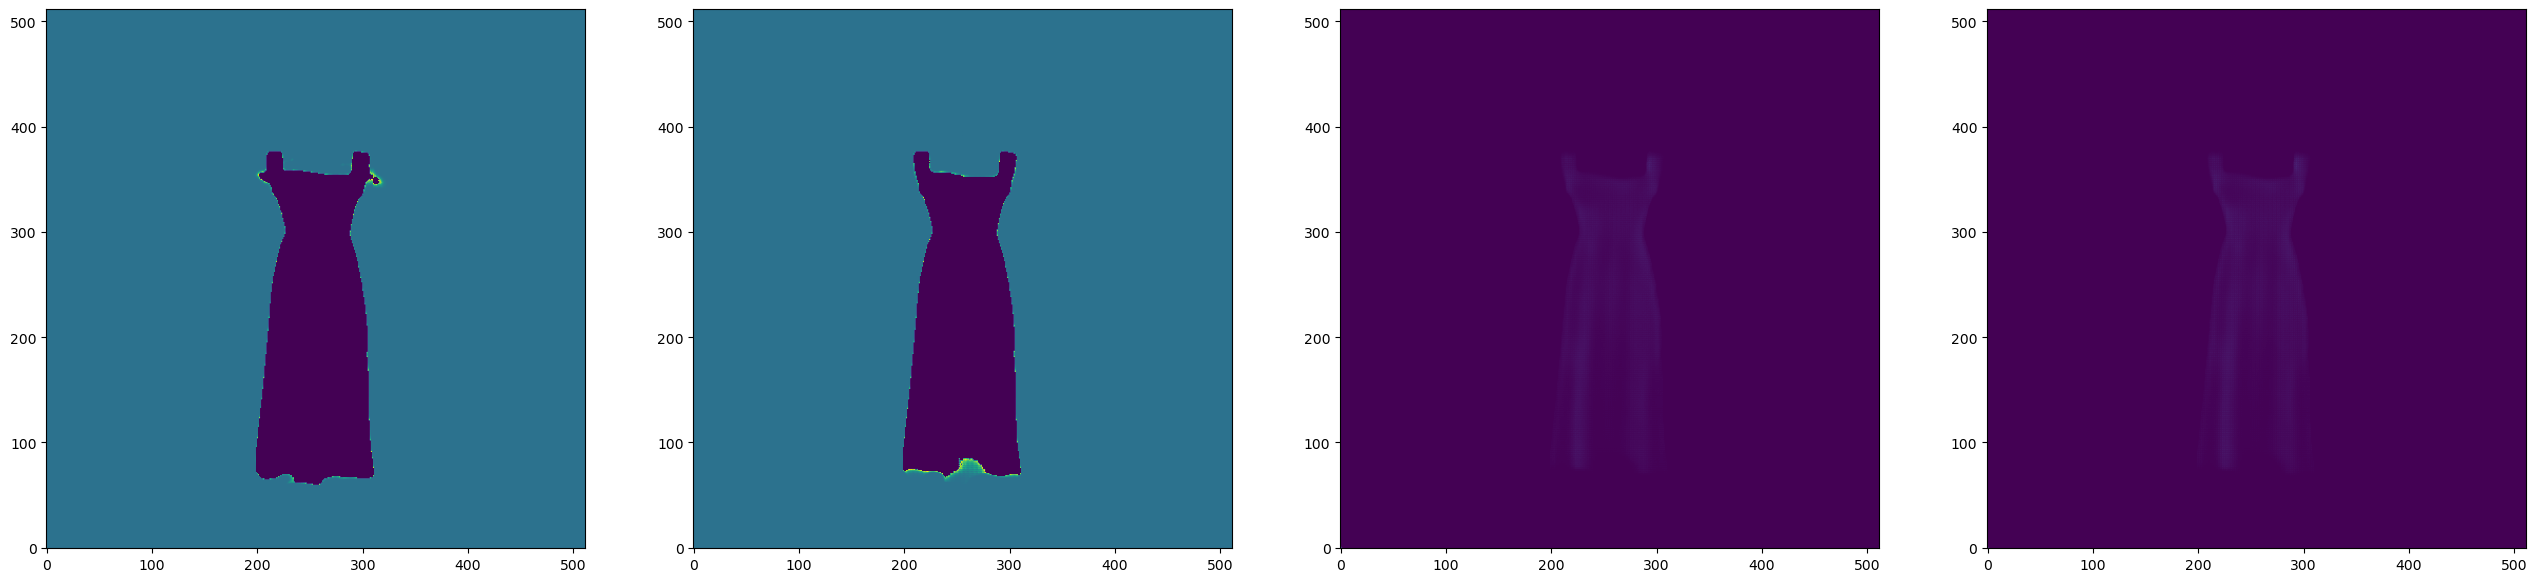

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


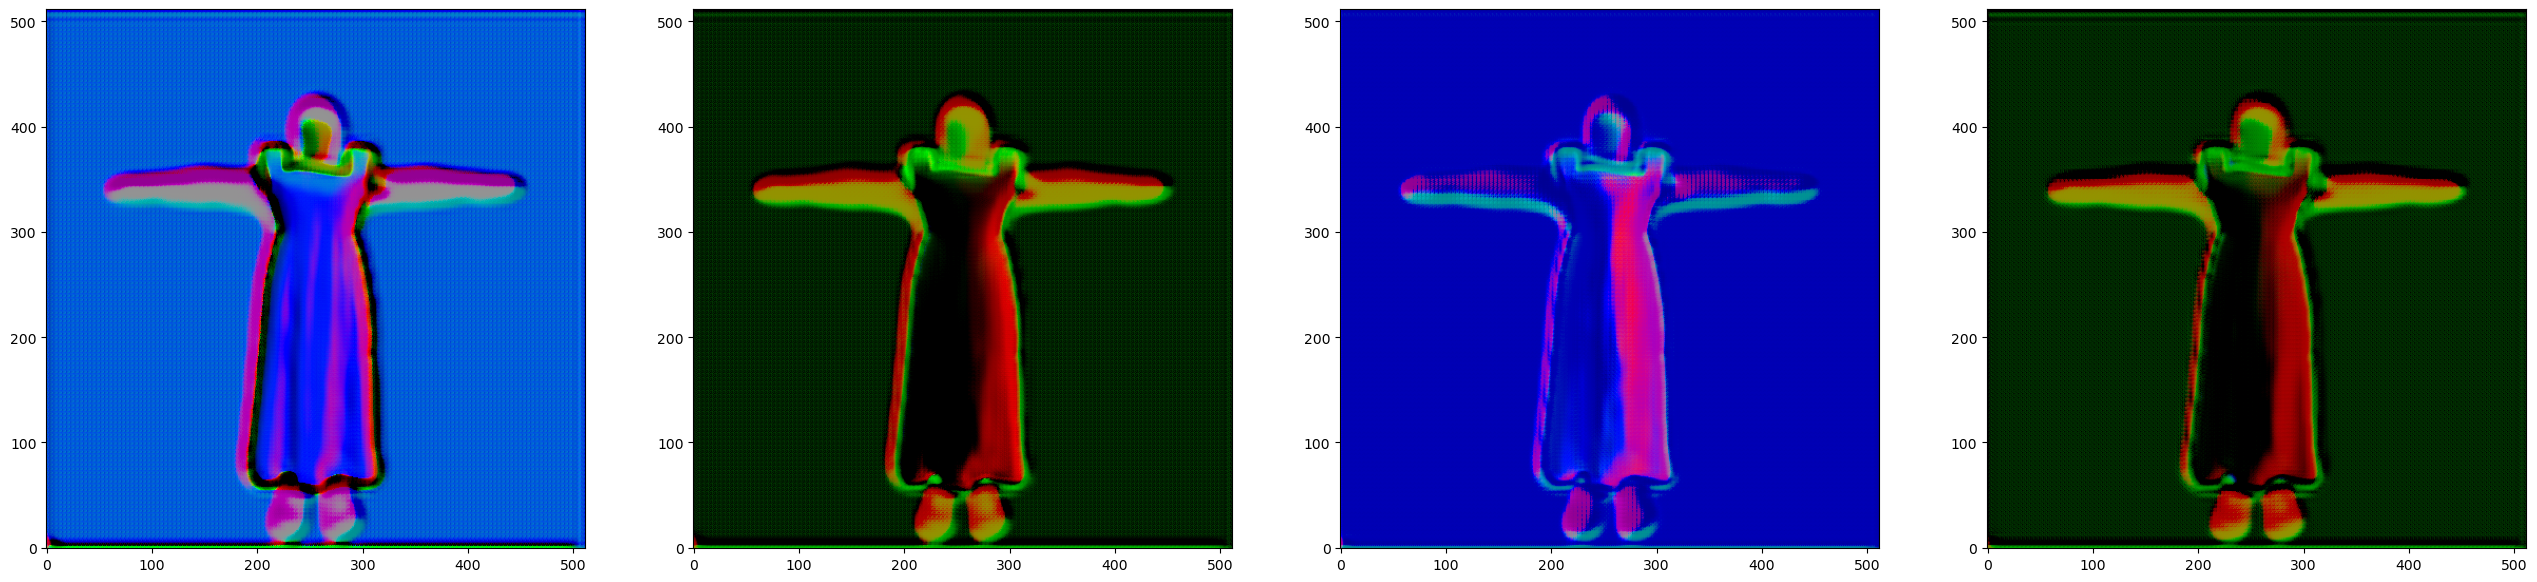

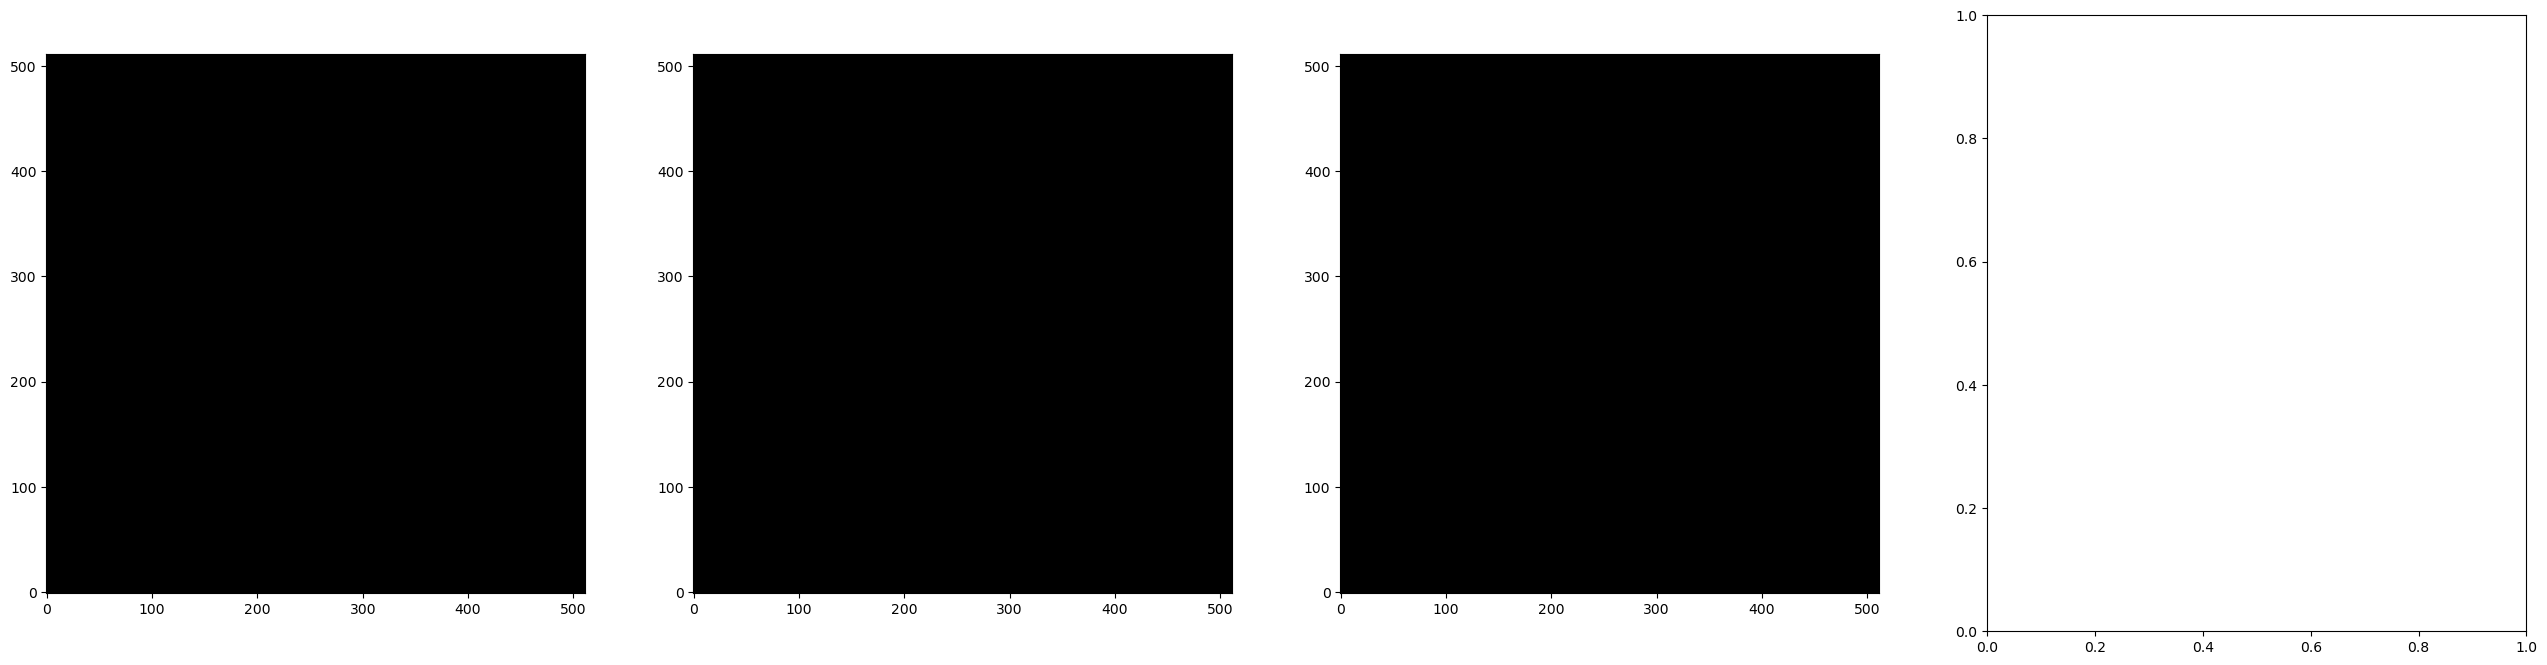

In [8]:
tmp = r["Depth"][0].cpu().detach().numpy().squeeze() - .5
tmp[np.abs(tmp) < thres] = 0
plot_depth(tmp)
plot_3d((r["Norm"][0].cpu().detach().numpy()))
plot_3d((r["RGB"][0].cpu().detach().numpy()))

In [9]:
from xcloth.components.reconstruct import GarmentModel3D

mesh = GarmentModel3D.from_tensor_dict(r, 1)

mesh[0].mask = d[1][0].squeeze().cpu().numpy()
mesh[0].mask = mesh[0].mask != 0

path = "C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r"

lowpoly = mesh[0].backproject(thres=thres, depth_offset=.5, path=path)

In [15]:
m = mesh[0].to_obj(
    path=os.path.join(path, "filtered.obj"), 
    smooth_iter=5, 
    lambda_filter=0.7, 
    # sampler_mesh=lowpoly, 
    sampler_depth=7,
    sampler_dilation=0.4
)

In [16]:
np.asarray(m.triangle_normals)

array([], shape=(0, 3), dtype=float64)